In [1]:
# ----------------- Import Libraries -----------------
# Mengimpor semua pustaka yang dibutuhkan untuk analisis dan pemodelan
import os                          # Untuk operasi file dan folder
import numpy as np                 # Untuk perhitungan numerik dan array
import pandas as pd                # Untuk manipulasi data dalam bentuk tabel (DataFrame)
from math import sqrt              # Fungsi matematika (akar kuadrat)
import joblib                      # Untuk menyimpan model ke file
import matplotlib.pyplot as plt    # Untuk visualisasi data
import seaborn as sns              # Untuk visualisasi data yang lebih menarik

# Modul-modul dari scikit-learn untuk preprocessing dan modeling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# Menentukan folder keluaran dan file dataset
OUT_DIR = "./polynomial_regression_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)  # Membuat folder jika belum ada
DATA_CSV = os.path.join(OUT_DIR, "synthetic_property_data.csv")
RANDOM_STATE = 42                    # Untuk hasil acak yang konsisten


In [3]:
if os.path.exists(DATA_CSV):
    # Jika dataset sudah ada, langsung dimuat dari file
    print("Memuat dataset:", DATA_CSV)
    df = pd.read_csv(DATA_CSV)
else:
    # Jika belum ada, buat dataset properti sintetis dengan 300 sampel
    print("Membuat dataset sintetik (n=300)...")
    np.random.seed(RANDOM_STATE)
    n = 300
    # Rentang nilai untuk tiap fitur
    RANGES = {
        "Luas_Tanah_m2": (50, 500),
        "Luas_Bangunan_m2": (30, 400),
        "Jumlah_Kamar": (1, 5),
        "Umur_Bangunan_th": (0, 30),
        "Jarak_ke_Pusat_km": (1, 20)
    }

    # Membuat data acak untuk setiap fitur
    luas_tanah = np.random.uniform(*RANGES["Luas_Tanah_m2"], n)
    luas_bangunan = np.random.uniform(*RANGES["Luas_Bangunan_m2"], n)
    jml_kamar = np.random.randint(*RANGES["Jumlah_Kamar"], n)
    umur = np.random.uniform(*RANGES["Umur_Bangunan_th"], n)
    jarak = np.random.uniform(*RANGES["Jarak_ke_Pusat_km"], n)

    # Koefisien dasar harga properti
    K_LT, K_LB, K_JK = 5e6, 7e6, 300e6
    # Formula non-linear untuk menghasilkan harga sintetis
    price = (
        200e6
        + K_LB * luas_bangunan
        + K_LT * luas_tanah
        + K_JK * jml_kamar
        + 0.5e6 * (luas_bangunan * jml_kamar)
        - 2e5 * (luas_tanah * jarak)
        - 8e6 * np.log(umur + 1)
        + 400e6 / (jarak + 0.5)
    )
    # Menambahkan noise acak agar data lebih realistis
    noise = np.random.normal(0, 0.15 * np.abs(price), n)
    price = np.clip(price + noise, 200e6, 5e9)  # Batasi nilai harga

    # Membuat DataFrame dan menyimpan ke file CSV
    df = pd.DataFrame({
        "Luas_Tanah_m2": luas_tanah,
        "Luas_Bangunan_m2": luas_bangunan,
        "Jumlah_Kamar": jml_kamar,
        "Umur_Bangunan_th": umur,
        "Jarak_ke_Pusat_km": jarak,
        "Harga_Juta": price
    })
    df.to_csv(DATA_CSV, index=False)
    print("Dataset disimpan ke:", DATA_CSV)

Membuat dataset sintetik (n=300)...
Dataset disimpan ke: ./polynomial_regression_artifacts/synthetic_property_data.csv



=== Ringkasan Dataset ===
       Luas_Tanah_m2  Luas_Bangunan_m2  Jumlah_Kamar  Umur_Bangunan_th  \
count     300.000000        300.000000    300.000000        300.000000   
mean      272.842070        219.007656      2.420000         14.615543   
std       132.453243        111.958434      1.089752          8.767212   
min        52.277713         34.009931      1.000000          0.138961   
25%       157.586362        122.357521      1.000000          6.842693   
50%       280.272978        223.030026      2.000000         14.877863   
75%       390.586827        316.136553      3.000000         21.969351   
max       495.524233        399.895539      4.000000         29.906228   

       Jarak_ke_Pusat_km    Harga_Juta  
count         300.000000  3.000000e+02  
mean           10.752880  3.474824e+09  
std             5.690081  1.114489e+09  
min             1.121332  9.044387e+08  
25%             5.429351  2.625137e+09  
50%            11.126160  3.489872e+09  
75%            15.6

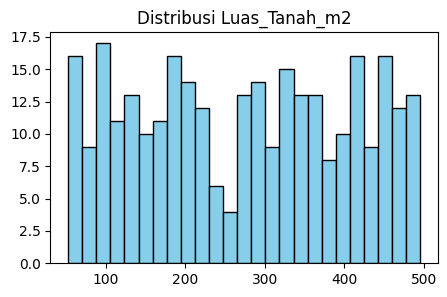

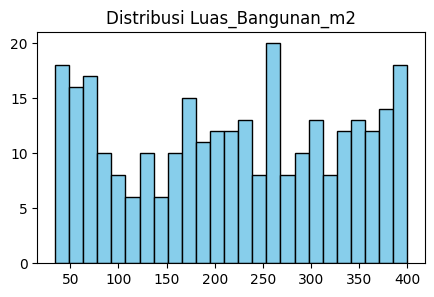

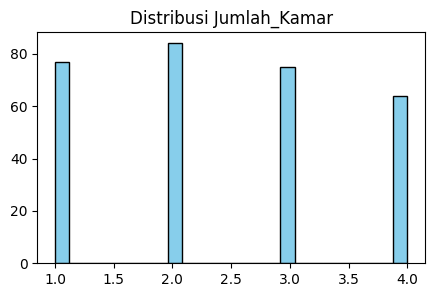

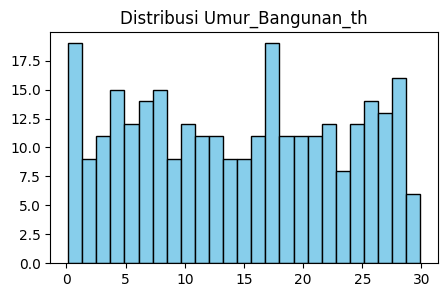

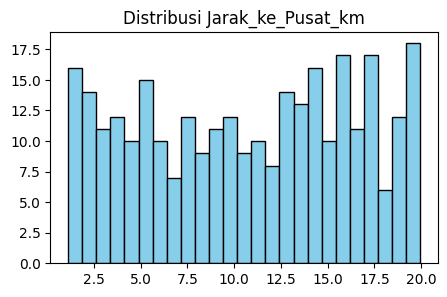

In [4]:
# ----------------- Exploratory Data Analysis (EDA) -----------------
print("\n=== Ringkasan Dataset ===")
print(df.describe())  # Statistik ringkasan setiap kolom

# Daftar fitur yang digunakan sebagai variabel independen
features = ["Luas_Tanah_m2","Luas_Bangunan_m2","Jumlah_Kamar","Umur_Bangunan_th","Jarak_ke_Pusat_km"]

# Membuat histogram untuk melihat distribusi setiap fitur
for col in features:
    plt.figure(figsize=(5,3))
    plt.hist(df[col], bins=25, color='skyblue', edgecolor='black')
    plt.title(f"Distribusi {col}")
    plt.show()

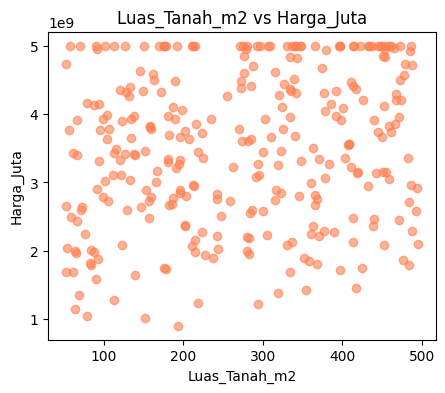

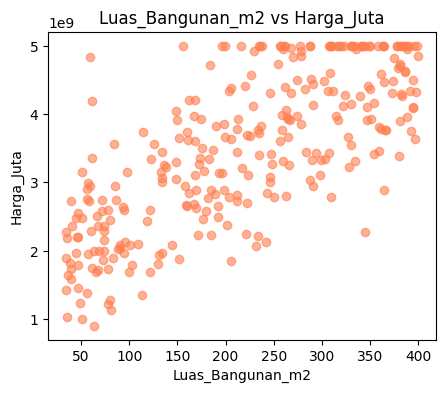

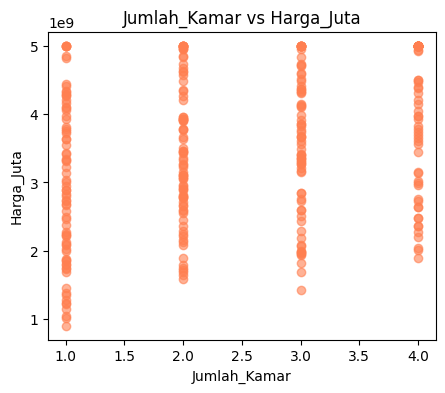

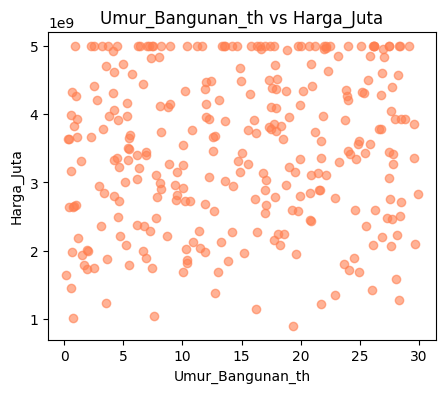

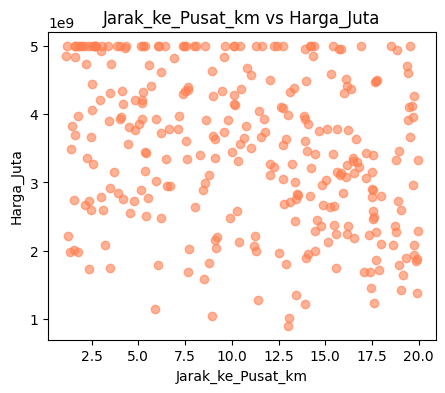

In [5]:
# Membuat scatter plot antara fitur dan harga
for col in features:
    plt.figure(figsize=(5,4))
    plt.scatter(df[col], df["Harga_Juta"], alpha=0.6, color='coral')
    plt.xlabel(col); plt.ylabel("Harga_Juta")
    plt.title(f"{col} vs Harga_Juta")
    plt.show()

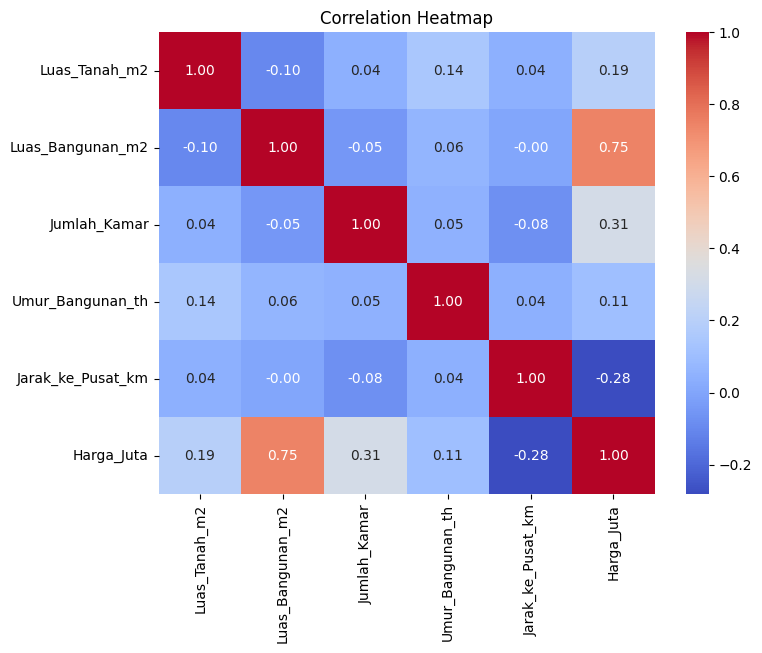

In [6]:
# Membuat heatmap korelasi antar variabel
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


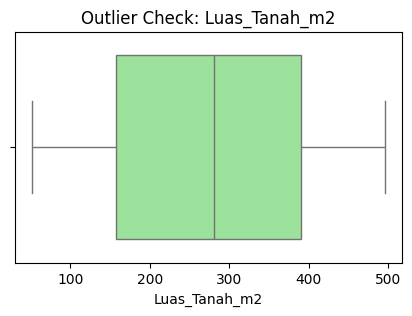

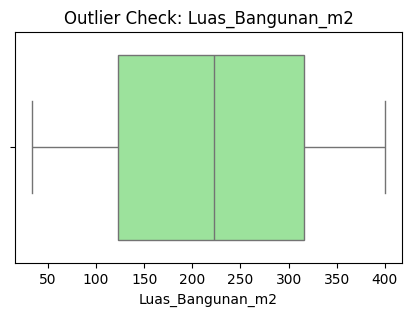

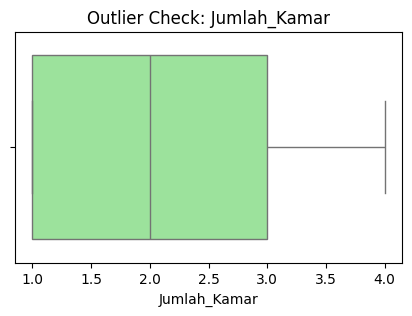

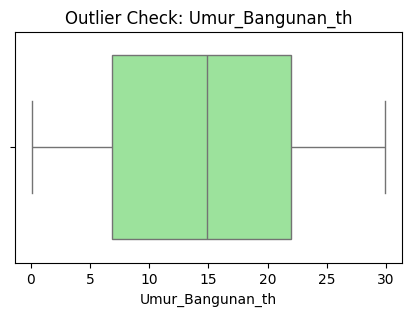

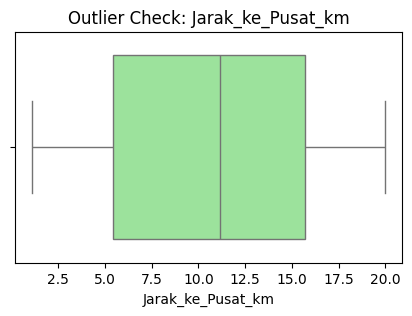

In [7]:
# Membuat boxplot untuk mendeteksi outlier
for col in features:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Outlier Check: {col}")
    plt.show()

In [8]:
# ----------------- Preprocessing -----------------
# Pisahkan fitur dan target
X = df[features].copy()
y = df["Harga_Juta"].copy()

# Split data menjadi data latih (70%) dan data uji (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Normalisasi data menggunakan StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [9]:
# ----------------- Model Training -----------------
# Menentukan berbagai derajat polinomial dan parameter regularisasi
degrees = [1,2,3,4,5]
alphas = [0.001,0.01,0.1,1,10,100]
results = []     # Menyimpan hasil evaluasi
models = {}      # Menyimpan model untuk tiap derajat

# Melatih model untuk setiap derajat polinomial
for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    Xtr_poly, Xte_poly = poly.fit_transform(X_train_s), poly.transform(X_test_s)

    # Latih model regresi linear
    lr = LinearRegression().fit(Xtr_poly, y_train)
    y_pred = lr.predict(Xte_poly)

    # Simpan hasil R² training dan testing
    results.append({
        "degree": deg,
        "model": "Linear",
        "train_r2": r2_score(y_train, lr.predict(Xtr_poly)),
        "test_r2": r2_score(y_test, y_pred)
    })
    models[f"deg{deg}_linear"] = {"poly": poly, "model": lr}


=== Perbandingan Model Berdasarkan Degree ===
   degree   model  train_r2    test_r2
0       1  Linear  0.814298   0.820541
1       2  Linear  0.854844   0.797498
2       3  Linear  0.873502   0.778438
3       4  Linear  0.921850   0.093930
4       5  Linear  1.000000 -17.329318


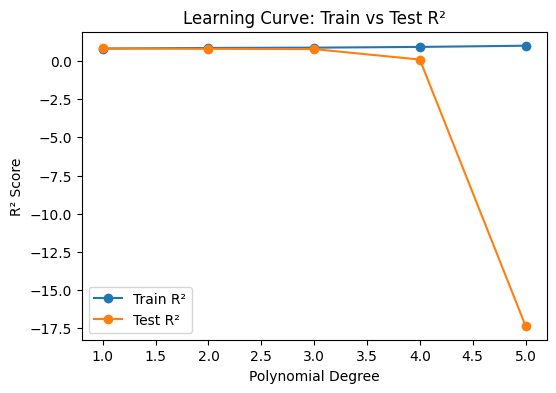

In [10]:
# Tampilkan hasil perbandingan model
results_df = pd.DataFrame(results)
print("\n=== Perbandingan Model Berdasarkan Degree ===")
print(results_df)

# Visualisasi learning curve berdasarkan nilai R²
plt.figure(figsize=(6,4))
plt.plot(results_df["degree"], results_df["train_r2"], marker='o', label="Train R²")
plt.plot(results_df["degree"], results_df["test_r2"], marker='o', label="Test R²")
plt.xlabel("Polynomial Degree"); plt.ylabel("R² Score")
plt.title("Learning Curve: Train vs Test R²")
plt.legend()
plt.show()

In [11]:
# ----------------- Cross Validation -----------------
# Validasi silang untuk menemukan degree terbaik
candidates = []
for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    Xpoly_all = poly.fit_transform(scaler.transform(X))
    lr = LinearRegression()
    sc = cross_val_score(lr, Xpoly_all, y, cv=5, scoring='r2')  # 5-fold CV
    candidates.append({"degree":deg,"cv_r2_mean":sc.mean(),"cv_r2_std":sc.std()})

candidates_df = pd.DataFrame(candidates).sort_values("cv_r2_mean", ascending=False)
print("\n=== Cross Validation R² ===")
print(candidates_df)



=== Cross Validation R² ===
   degree  cv_r2_mean  cv_r2_std
1       2    0.810633   0.035113
0       1    0.807152   0.032025
2       3    0.769227   0.023913
3       4    0.469866   0.130670
4       5 -133.141010  87.859133


In [12]:
# Ambil degree terbaik berdasarkan rata-rata R² tertinggi
best = candidates_df.iloc[0]
deg_best = int(best["degree"])
poly_best = models[f"deg{deg_best}_linear"]["poly"]
model_best = models[f"deg{deg_best}_linear"]["model"]

# Simpan model, polynomial transformer, dan scaler ke file
joblib.dump(model_best, os.path.join(OUT_DIR,"best_model.pkl"))
joblib.dump(poly_best, os.path.join(OUT_DIR,"best_poly.pkl"))
joblib.dump(scaler, os.path.join(OUT_DIR,"scaler.pkl"))
print("Model terbaik disimpan!")

Model terbaik disimpan!


In [13]:
# ----------------- Regularization (Degree=2) -----------------
# Uji pengaruh regularisasi (Ridge & Lasso) pada polynomial degree 2
deg_target = 2
poly_target = PolynomialFeatures(degree=deg_target, include_bias=False)
Xtr_poly_t, Xte_poly_t = poly_target.fit_transform(X_train_s), poly_target.transform(X_test_s)

ridge_scores, lasso_scores = [], []
for a in alphas:
    ridge = Ridge(alpha=a, max_iter=10000).fit(Xtr_poly_t, y_train)
    lasso = Lasso(alpha=a, max_iter=10000).fit(Xtr_poly_t, y_train)
    ridge_scores.append((a, r2_score(y_test, ridge.predict(Xte_poly_t))))
    lasso_scores.append((a, r2_score(y_test, lasso.predict(Xte_poly_t))))

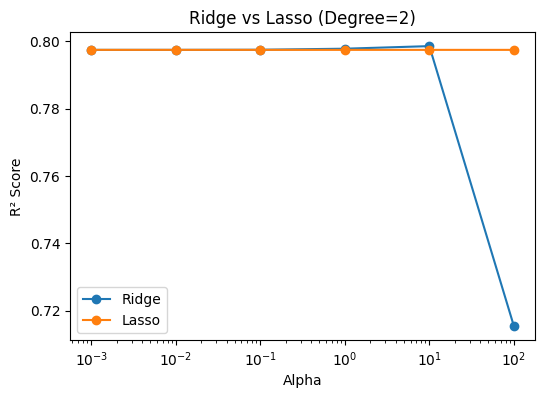

In [14]:
# Visualisasi hasil regularisasi
plt.figure(figsize=(6,4))
plt.plot([a for a,_ in ridge_scores],[s for _,s in ridge_scores], marker='o', label='Ridge')
plt.plot([a for a,_ in lasso_scores],[s for _,s in lasso_scores], marker='o', label='Lasso')
plt.xscale('log')
plt.xlabel("Alpha"); plt.ylabel("R² Score")
plt.title("Ridge vs Lasso (Degree=2)")
plt.legend()
plt.show()

In [15]:
#  Ambil nilai alpha terbaik untuk Ridge dan Lasso
best_ridge = max(ridge_scores,key=lambda x:x[1])
best_lasso = max(lasso_scores,key=lambda x:x[1])

print(f"\nBest Ridge: alpha={best_ridge[0]}, R²={best_ridge[1]:.4f}")
print(f"Best Lasso: alpha={best_lasso[0]}, R²={best_lasso[1]:.4f}")


Best Ridge: alpha=10, R²=0.7986
Best Lasso: alpha=100, R²=0.7975


In [16]:
# ----------------- Report -----------------
# Membuat laporan hasil
report_path = os.path.join(OUT_DIR,"report.md")
with open(report_path,"w") as f:
    f.write("# Polynomial Regression Project - Report\n\n")
    f.write("## 1. Executive Summary\n")
    f.write(f"- Dataset: {len(df)} sampel properti\n")
    f.write(f"- Best Polynomial Degree: {deg_best}\n")
    f.write(f"- Best CV R² (Linear Model): {best['cv_r2_mean']:.4f}\n")
    f.write(f"- Best Regularization (Degree=2): Ridge alpha={best_ridge[0]}, R²={best_ridge[1]:.4f}\n\n")

    f.write("## 2. Insights dari EDA\n")
    f.write("- Fitur Luas_Bangunan_m2 & Luas_Tanah_m2 memiliki korelasi positif terhadap harga.\n")
    f.write("- Jarak_ke_Pusat_km berkorelasi negatif terhadap harga.\n")
    f.write("- Outlier terlihat pada Luas_Tanah_m2 dan Harga_Juta.\n\n")

    f.write("## 3. Perbandingan Performa Model\n")
    f.write(results_df.to_markdown(index=False))
    f.write("\n\n")

    f.write("## 4. Rekomendasi\n")
    f.write(f"- Polynomial Degree terbaik: {deg_best}\n")
    f.write(f"- Regularization terbaik: Ridge (alpha={best_ridge[0]})\n\n")

    f.write("## 5. Limitasi Model\n")
    f.write("- Fitur terbatas, belum mencakup lokasi mikro & kondisi bangunan.\n")
    f.write("- Sensitif terhadap outlier besar.\n")
    f.write("- CI prediksi berbasis residual sederhana.\n\n")

    f.write("## 6. Saran Improvement\n")
    f.write("- Tambahkan fitur kualitatif (lingkungan, fasilitas).\n")
    f.write("- Gunakan model tree-based (RandomForest/XGBoost).\n")
    f.write("- Evaluasi dengan cross-validation lebih kompleks.\n")

print(f"\n✅ Report disimpan di: {report_path}")
print(f"✅ Model & Dataset disimpan di folder: {OUT_DIR}")


✅ Report disimpan di: ./polynomial_regression_artifacts/report.md
✅ Model & Dataset disimpan di folder: ./polynomial_regression_artifacts
